# Fire Risk Analysis: Climate Change Impact Assessment

## Simple Fire Weather Model Applied to MACA Climate Projections

This notebook demonstrates:
1. **Simple Fire Risk Calculation** - Emperical model combining temperature, precipitation, wind, and humidity
2. **Climate Scenario Comparison** - Historical (1950-2005) vs RCP 8.5 (2006-2099)
3. **Extreme Event Analysis** - Days exceeding critical fire risk thresholds
4. **Data Product Creation** - Saving analysis results to Arraylake

### Platform Demonstration:
- **Arraylake**: Cloud-native data lake with instant access
- **Icechunk**: Version control for reproducible science
- **Xarray**: Data model and toolkit for labeled N-D arrays
- **Dask**: Scalable computation on multi-TB datasets

### Business Value:
Insurance providers and risk managers can use fire risk trends to:
- Quantify changing wildfire exposure
- Adjust portfolio risk models
- Price climate risk into policies
- Develop and implement mitigation strategies

## Setup

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import arraylake as al
import coiled
from dask.distributed import progress
from fire_risk import calculate_fire_risk_index_from_maca

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Fire risk threshold for "extreme fire weather days"
FIRE_RISK_THRESHOLD = 75  # High fire risk (0-100 scale)

## 1. Connect to MACA Data on Arraylake

Load climate projections from the `earthmover-demos` catalog in Arraylake.

In [2]:
# Authenticate with Arraylake
al_client = al.Client()
# al_client.login()  # Uncomment if needed

# Connect to the MACA repository
repo_name = "earthmover-demos/maca-v2-metdata"
branch = "maca-v2-metdata"

repo = al_client.get_repo("earthmover-demos/maca-v2-metdata")
session = repo.readonly_session(branch=branch)

print(f"Connected to: {repo_name}")
print(f"Latest commit: {next(repo.ancestry(branch=branch)).id}")

Connected to: earthmover-demos/maca-v2-metdata
Latest commit: V77VC08Y5CKVBW5CZD7G


## 2. Define Analysis Region and Models

Focus on Western US where wildfire risk is highest.

In [3]:
# Western US bounding box (MACA grid uses lon 0-360)
west_bbox = {'lat': slice(31, 49), 'lon': slice(235, 260)}

# Select ONE model for demonstration
model = 'CanESM2'

print(f"Analysis Configuration:")
print(f"  Region: Western US (lat {west_bbox['lat']}, lon {west_bbox['lon']})")
print(f"  Model: {model}")
print(f"  Fire Risk Threshold: {FIRE_RISK_THRESHOLD} (High fire risk on 0-100 scale)")

Analysis Configuration:
  Region: Western US (lat slice(31, 49, None), lon slice(235, 260, None))
  Model: CanESM2
  Fire Risk Threshold: 75 (High fire risk on 0-100 scale)


## 3. Load Historical Data (1950-2005)

Baseline period for comparison.

In [4]:
print("Loading historical data (1950-2005)...")

# Open historical group
ds_hist = xr.open_zarr(
    session.store,
    zarr_format=3,
    group="daily/historical"
)

print(f"✓ Historical data loaded")
print(f"  Shape: {dict(ds_hist.sizes)}")
print(f"  Variables: {list(ds_hist.data_vars)}")
print(f"  Time range: {str(ds_hist.time.values[0])[:10]} to {str(ds_hist.time.values[-1])[:10]}")
ds_hist

Loading historical data (1950-2005)...
✓ Historical data loaded
  Shape: {'time': 20454, 'lat': 585, 'lon': 1386, 'model': 18}
  Variables: ['huss', 'rhsmin', 'pr', 'tasmax', 'tasmin', 'rhsmax', 'rsds', 'vas', 'vpd', 'uas']
  Time range: 1950-01-01 to 2005-12-31


<xarray.Dataset> Size: 12TB
Dimensions:  (time: 20454, lat: 585, lon: 1386, model: 18)
Coordinates:
  * time     (time) datetime64[ns] 164kB 1950-01-01 1950-01-02 ... 2005-12-31
  * lat      (lat) float64 5kB 25.06 25.1 25.15 25.19 ... 49.27 49.31 49.35 49.4
  * lon      (lon) float64 11kB 235.2 235.3 235.3 235.4 ... 292.9 292.9 292.9
  * model    (model) <U14 1kB 'BNU-ESM' 'CNRM-CM5' ... 'bcc-csm1-1-m' 'inmcm4'
Data variables:
    huss     (time, lat, lon, model) float32 1TB dask.array<chunksize=(365, 180, 180, 1), meta=np.ndarray>
    rhsmin   (time, lat, lon, model) float32 1TB dask.array<chunksize=(365, 180, 180, 1), meta=np.ndarray>
    pr       (time, lat, lon, model) float32 1TB dask.array<chunksize=(365, 180, 180, 1), meta=np.ndarray>
    tasmax   (time, lat, lon, model) float32 1TB dask.array<chunksize=(365, 180, 180, 1), meta=np.ndarray>
    tasmin   (time, lat, lon, model) float32 1TB dask.array<chunksize=(365, 180, 180, 1), meta=np.ndarray>
    rhsmax   (time, lat, lon, model) float32 1TB dask.array<chunksize=(365, 180, 180, 1), meta=np.ndarray>
    rsds     (time, lat, lon, model) float32 1TB dask.array<chunksize=(365, 180, 180, 1), meta=np.ndarray>
    vas      (time, lat, lon, model) float32 1TB dask.array<chunksize=(365, 180, 180, 1), meta=np.ndarray>
    vpd      (time, lat, lon, model) float32 1TB dask.array<chunksize=(365, 180, 180, 1), meta=np.ndarray>
    uas      (time, lat, lon, model) float32 1TB dask.array<chunksize=(365, 180, 180, 1), meta=np.ndarray>
Attributes:
    title:               MACAv2-METDATA Cloud-Optimized Analysis-Ready Data
    source:              Northwest Knowledge Network HTTP Server
    scenario:            historical
    frequency:           daily
    models:              BNU-ESM, CNRM-CM5, CSIRO-Mk3-6-0, CanESM2, GFDL-ESM2...
    variables:           tasmax, tasmin, pr, rsds, huss, uas, vas, vpd, rhsma...
    history:             Created by Earthmover PBC on 2025-11-04 13:05:02
    references:          Abatzoglou J.T. and Brown T.J. (2012)
    spatial_resolution:  1/24 degree (~4 km)
    domain:              CONUS

In [5]:
# Select region, time period, and single model
ds_hist = ds_hist.sel(
    **west_bbox,
    time=slice('1950', '2005'),
    model=model
)

print(f"✓ Historical data loaded")
print(f"  Shape: {dict(ds_hist.sizes)}")
print(f"  Variables: {list(ds_hist.data_vars)}")
print(f"  Time range: {str(ds_hist.time.values[0])[:10]} to {str(ds_hist.time.values[-1])[:10]}")
ds_hist

✓ Historical data loaded
  Shape: {'time': 20454, 'lat': 432, 'lon': 595}
  Variables: ['huss', 'rhsmin', 'pr', 'tasmax', 'tasmin', 'rhsmax', 'rsds', 'vas', 'vpd', 'uas']
  Time range: 1950-01-01 to 2005-12-31


<xarray.Dataset> Size: 210GB
Dimensions:  (time: 20454, lat: 432, lon: 595)
Coordinates:
  * time     (time) datetime64[ns] 164kB 1950-01-01 1950-01-02 ... 2005-12-31
  * lat      (lat) float64 3kB 31.02 31.06 31.1 31.15 ... 48.85 48.9 48.94 48.98
  * lon      (lon) float64 5kB 235.2 235.3 235.3 235.4 ... 259.9 259.9 260.0
    model    <U14 56B 'CanESM2'
Data variables:
    huss     (time, lat, lon) float32 21GB dask.array<chunksize=(365, 37, 180), meta=np.ndarray>
    rhsmin   (time, lat, lon) float32 21GB dask.array<chunksize=(365, 37, 180), meta=np.ndarray>
    pr       (time, lat, lon) float32 21GB dask.array<chunksize=(365, 37, 180), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 21GB dask.array<chunksize=(365, 37, 180), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 21GB dask.array<chunksize=(365, 37, 180), meta=np.ndarray>
    rhsmax   (time, lat, lon) float32 21GB dask.array<chunksize=(365, 37, 180), meta=np.ndarray>
    rsds     (time, lat, lon) float32 21GB dask.array<chunksize=(365, 37, 180), meta=np.ndarray>
    vas      (time, lat, lon) float32 21GB dask.array<chunksize=(365, 37, 180), meta=np.ndarray>
    vpd      (time, lat, lon) float32 21GB dask.array<chunksize=(365, 37, 180), meta=np.ndarray>
    uas      (time, lat, lon) float32 21GB dask.array<chunksize=(365, 37, 180), meta=np.ndarray>
Attributes:
    title:               MACAv2-METDATA Cloud-Optimized Analysis-Ready Data
    source:              Northwest Knowledge Network HTTP Server
    scenario:            historical
    frequency:           daily
    models:              BNU-ESM, CNRM-CM5, CSIRO-Mk3-6-0, CanESM2, GFDL-ESM2...
    variables:           tasmax, tasmin, pr, rsds, huss, uas, vas, vpd, rhsma...
    history:             Created by Earthmover PBC on 2025-11-04 13:05:02
    references:          Abatzoglou J.T. and Brown T.J. (2012)
    spatial_resolution:  1/24 degree (~4 km)
    domain:              CONUS

## 4. Load RCP 8.5 Data (2006-2099)

High emissions scenario representing business-as-usual.

In [6]:
print("Loading RCP 8.5 data (2006-2099)...")

# Open RCP 8.5 group
ds_rcp85 = xr.open_zarr(
    session.store,
    zarr_format=3,
    group="daily/rcp85"
)

# Select region, time period, and single model
ds_rcp85 = ds_rcp85.sel(
    **west_bbox,
    time=slice('2006', '2099'),
    model=model
)

print(f"✓ RCP 8.5 data loaded")
print(f"  Shape: {dict(ds_rcp85.sizes)}")
print(f"  Time range: {str(ds_rcp85.time.values[0])[:10]} to {str(ds_rcp85.time.values[-1])[:10]}")

Loading RCP 8.5 data (2006-2099)...
✓ RCP 8.5 data loaded
  Shape: {'time': 34333, 'lat': 432, 'lon': 595}
  Time range: 2006-01-01 to 2099-12-31


## 5. Calculate Fire Risk Index - Historical

Calculate simple fire risk index combining temperature, precipitation, wind, and humidity.

In [7]:
calculate_fire_risk_index_from_maca?

Signature:
calculate_fire_risk_index_from_maca(
    ds: xarray.core.dataset.Dataset,
    tasmax_var: str = 'tasmax',
    pr_var: str = 'pr',
    uas_var: str = 'uas',
    vas_var: str = 'vas',
    rhsmin_var: str = 'rhsmin',
    temp_weight: float = 0.4,
    precip_weight: float = 0.3,
    wind_weight: float = 0.15,
    rh_weight: float = 0.15,
) -> xarray.core.dataarray.DataArray
Docstring:
Calculate fire risk index directly from MACA dataset.

This is a wrapper that handles MACA data format and calls the main
fire risk calculation.

Parameters
----------
ds : xr.Dataset
    MACA dataset containing required variables
tasmax_var : str
    Name of max temperature variable (default 'tasmax')
pr_var : str
    Name of precipitation variable (default 'pr')
uas_var : str
    Name of eastward wind variable (default 'uas')
vas_var : str
    Name of northward wind variable (default 'vas')
rhsmin_var : str
    Name of minimum relative humidity variable (default 'rhsmin')
temp_weight : float
    

In [8]:
print("Calculating fire risk for historical period...")
print("  This creates a lazy computation graph (no actual computation yet)")

fire_risk_hist = calculate_fire_risk_index_from_maca(ds_hist)

print(f"✓ Fire risk calculation set up (lazy)")
print(f"  Shape: {dict(fire_risk_hist.sizes)}")
print(f"  Range: 0-100 (higher = more risk)")
fire_risk_hist

Calculating fire risk for historical period...
  This creates a lazy computation graph (no actual computation yet)
✓ Fire risk calculation set up (lazy)
  Shape: {'time': 20454, 'lat': 432, 'lon': 595}
  Range: 0-100 (higher = more risk)


<xarray.DataArray (time: 20454, lat: 432, lon: 595)> Size: 21GB
dask.array<add, shape=(20454, 432, 595), dtype=float32, chunksize=(365, 180, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 164kB 1950-01-01 1950-01-02 ... 2005-12-31
  * lat      (lat) float64 3kB 31.02 31.06 31.1 31.15 ... 48.85 48.9 48.94 48.98
  * lon      (lon) float64 5kB 235.2 235.3 235.3 235.4 ... 259.9 259.9 260.0
    model    <U14 56B 'CanESM2'
Attributes:
    long_name:    Fire Risk Index
    units:        index
    valid_range:  [0, 100]
    description:  Simplified fire risk index combining temperature, precipita...

## 6. Calculate Fire Risk Index - RCP 8.5

Same calculation for future scenario.

In [9]:
print("Calculating fire risk for RCP 8.5 period...")

fire_risk_rcp85 = calculate_fire_risk_index_from_maca(ds_rcp85)

print(f"✓ Fire risk calculation set up (lazy)")
print(f"  Shape: {dict(fire_risk_rcp85.sizes)}")

Calculating fire risk for RCP 8.5 period...
✓ Fire risk calculation set up (lazy)
  Shape: {'time': 34333, 'lat': 432, 'lon': 595}


## 7. Calculate Extreme Fire Risk Days

**Key Metric**: Annual count of days where fire risk exceeds threshold.

This metric is critical for insurance risk assessment:
- Fire Risk > 70 = High fire risk (on 0-100 scale)
- Combines temperature, precipitation, wind, and humidity
- Transparent, interpretable model for business applications

In [10]:
print(f"Calculating extreme fire risk days (Fire Risk > {FIRE_RISK_THRESHOLD})...")
print("  Historical: Annual counts for 1950-2005")
print("  RCP 8.5: Annual counts for 2006-2099")

# Historical: count days per year where fire risk > threshold
extreme_days_hist = (
    (fire_risk_hist > FIRE_RISK_THRESHOLD)
    .resample(time='YE')
    .sum()
)

# RCP 8.5: same calculation
extreme_days_rcp85 = (
    (fire_risk_rcp85 > FIRE_RISK_THRESHOLD)
    .resample(time='YE')
    .sum()
)

print(f"✓ Extreme day calculations set up (lazy)")
print(f"  Historical shape: {extreme_days_hist.shape}")
print(f"  RCP 8.5 shape: {extreme_days_rcp85.shape}")

Calculating extreme fire risk days (Fire Risk > 75)...
  Historical: Annual counts for 1950-2005
  RCP 8.5: Annual counts for 2006-2099
✓ Extreme day calculations set up (lazy)
  Historical shape: (56, 432, 595)
  RCP 8.5 shape: (94, 432, 595)


## 8. Setup Coiled Cluster for Distributed Computation

**Platform Demo**: Use Coiled for scalable cloud computation.

This computation will process ~140 GB of data. A distributed cluster provides:
- Parallel processing across multiple workers
- Progress monitoring via Dask dashboard
- Automatic scaling and resource management

In [11]:
print("Setting up Coiled cluster...")

# Create Coiled cluster
cluster = coiled.Cluster(
    name="fwi-analysis",
    software="earthmover-demos",
    n_workers=50,        # 50 workers for parallel processing
    region="us-east-1",  # Same region as data
    workspace="earthmover-devs",
    spot_policy="spot",  # Use on-demand instances for reliability
)

# Connect to Dask client
dask_client = cluster.get_client()

Setting up Coiled cluster...


Output()

2025-11-06 17:46:38,557 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


## 9. Compute Summary Statistics with Distributed Progress

Calculate summary statistics for each period.

In [12]:
print(f"  Processing: Fire risk data for single model (CanESM2)")
print()

# Persist extreme days arrays in cluster memory for faster computation
print("Step 1: Persisting extreme days data in cluster memory...")
extreme_days_hist_persisted = extreme_days_hist.persist()
extreme_days_rcp85_persisted = extreme_days_rcp85.persist()

# Wait for persist to complete
_ = progress(extreme_days_hist_persisted, extreme_days_rcp85_persisted)
print("  ✓ Data persisted in cluster memory")
print()

# Compute means
print("Step 2: Computing historical mean...")
hist_future = dask_client.compute(extreme_days_hist_persisted)
progress(hist_future)
extreme_days_hist_mean = hist_future.result()
print("  ✓ Historical mean computed")
print()

print("Step 3: Computing RCP 8.5 mean...")
rcp85_future = dask_client.compute(extreme_days_rcp85_persisted)
progress(rcp85_future)
extreme_days_rcp85_mean = rcp85_future.result()
print("  ✓ RCP 8.5 mean computed")
print()

print("✓ All computations complete!")

# Quick statistics
hist_avg = float(extreme_days_hist_mean.mean())
rcp85_avg = float(extreme_days_rcp85_mean.mean())
change_pct = ((rcp85_avg - hist_avg) / hist_avg) * 100

print()
print(f"Western US Average (CanESM2 model):")
print(f"  Historical (1950-2005): {hist_avg:.1f} extreme fire risk days/year")
print(f"  RCP 8.5 (2006-2099): {rcp85_avg:.1f} extreme fire risk days/year")
print(f"  Change: +{change_pct:.1f}%")

  Processing: Fire risk data for single model (CanESM2)

Step 1: Persisting extreme days data in cluster memory...
  ✓ Data persisted in cluster memory

Step 2: Computing historical mean...
  ✓ Historical mean computed

Step 3: Computing RCP 8.5 mean...
  ✓ RCP 8.5 mean computed

✓ All computations complete!

Western US Average (CanESM2 model):
  Historical (1950-2005): 45.4 extreme fire risk days/year
  RCP 8.5 (2006-2099): 73.3 extreme fire risk days/year
  Change: +61.3%


## 10. Visualize Spatial Patterns

Maps showing mean annual extreme fire weather days for each period.

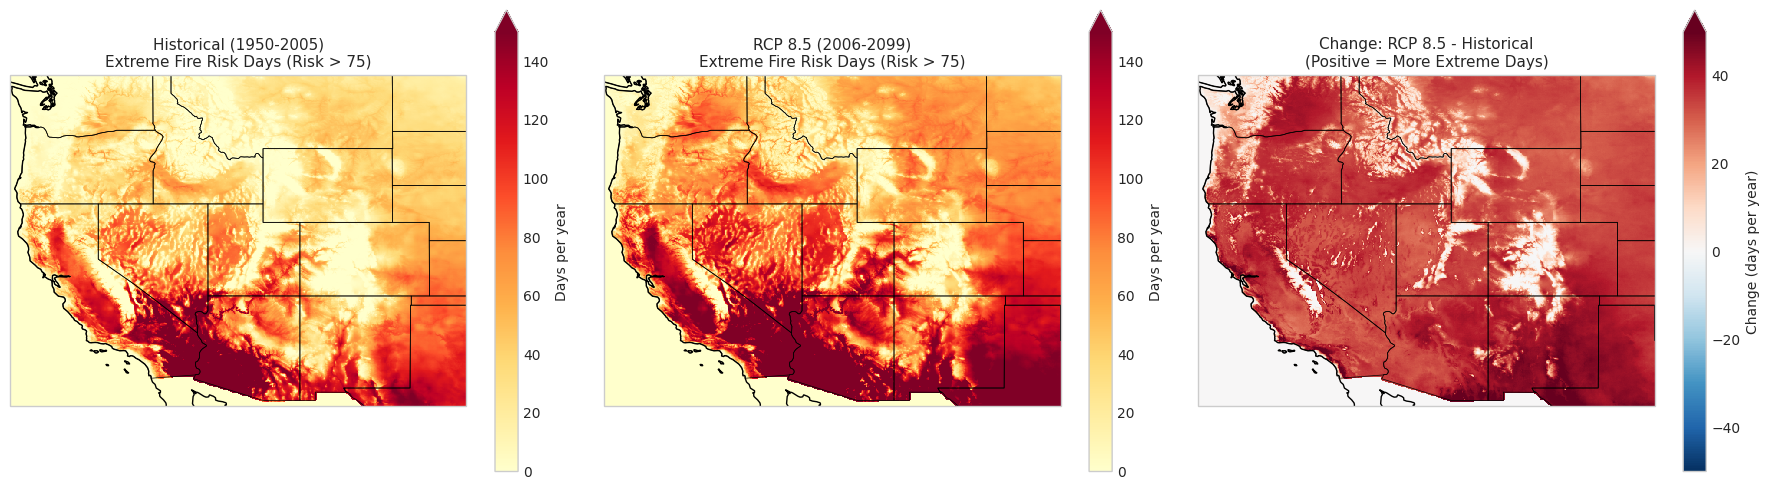


Spatial Statistics:
  Maximum increase: 65.5 days/year
  Grid cells with >20 day increase: 198297 / 257040


In [13]:
# Calculate time-mean for mapping
hist_map = extreme_days_hist_mean.mean(dim='time')
rcp85_map = extreme_days_rcp85_mean.mean(dim='time')
change_map = rcp85_map - hist_map

# Create figure
fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 5),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Plot 1: Historical
ax1 = axes[0]
hist_map.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap='YlOrRd',
    vmin=0,
    vmax=150,
    cbar_kwargs={'label': 'Days per year'}
)
ax1.coastlines()
ax1.add_feature(cfeature.STATES, linewidth=0.5)
ax1.set_title(f'Historical (1950-2005)\nExtreme Fire Risk Days (Risk > {FIRE_RISK_THRESHOLD})', fontsize=11)

# Plot 2: RCP 8.5
ax2 = axes[1]
rcp85_map.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap='YlOrRd',
    vmin=0,
    vmax=150,
    cbar_kwargs={'label': 'Days per year'}
)
ax2.coastlines()
ax2.add_feature(cfeature.STATES, linewidth=0.5)
ax2.set_title(f'RCP 8.5 (2006-2099)\nExtreme Fire Risk Days (Risk > {FIRE_RISK_THRESHOLD})', fontsize=11)

# Plot 3: Change
ax3 = axes[2]
change_map.plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    vmin=-50,
    vmax=50,
    cbar_kwargs={'label': 'Change (days per year)'}
)
ax3.coastlines()
ax3.add_feature(cfeature.STATES, linewidth=0.5)
ax3.set_title('Change: RCP 8.5 - Historical\n(Positive = More Extreme Days)', fontsize=11)

plt.tight_layout()
plt.show()

print(f"\nSpatial Statistics:")
print(f"  Maximum increase: {float(change_map.max()):.1f} days/year")
print(f"  Grid cells with >20 day increase: {int((change_map > 20).sum())} / {int(change_map.size)}")

## 10. Temporal Trends

Time series showing evolution of extreme fire weather days.

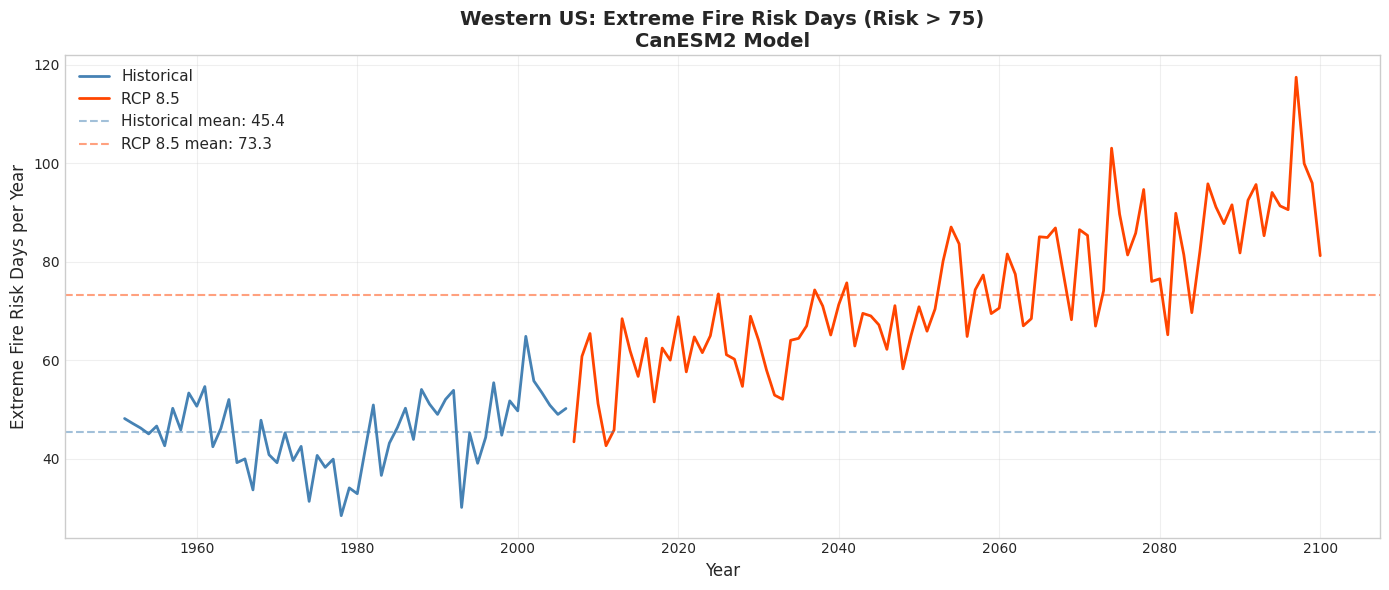

In [14]:
# Calculate spatial mean for time series
hist_ts = extreme_days_hist_mean.mean(dim=['lat', 'lon'])
rcp85_ts = extreme_days_rcp85_mean.mean(dim=['lat', 'lon'])

# Plot time series
fig, ax = plt.subplots(figsize=(14, 6))

# Historical period
hist_ts.plot(
    ax=ax,
    label='Historical',
    color='steelblue',
    linewidth=2
)

# RCP 8.5 period
rcp85_ts.plot(
    ax=ax,
    label='RCP 8.5',
    color='orangered',
    linewidth=2
)

# Period means
ax.axhline(
    float(hist_ts.mean()),
    color='steelblue',
    linestyle='--',
    alpha=0.5,
    label=f'Historical mean: {float(hist_ts.mean()):.1f}'
)
ax.axhline(
    float(rcp85_ts.mean()),
    color='orangered',
    linestyle='--',
    alpha=0.5,
    label=f'RCP 8.5 mean: {float(rcp85_ts.mean()):.1f}'
)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Extreme Fire Risk Days per Year', fontsize=12)
ax.set_title(
    f'Western US: Extreme Fire Risk Days (Risk > {FIRE_RISK_THRESHOLD})\nCanESM2 Model',
    fontsize=14,
    fontweight='bold'
)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Create Summary Dataset

Package the percent change analysis into a clean, single-variable dataset.

**Output**: One DataArray showing percent change in extreme fire risk days comparing:
- **Historical**: 1980-2000 (20-year period)
- **Future**: 2040-2060 (20-year period, RCP 8.5)

In [15]:
print("Creating summary dataset...")

# Define comparison periods
hist_period = slice('1980', '2000')
future_period = slice('2040', '2060')

print(f"  Historical period: {hist_period.start}-{hist_period.stop}")
print(f"  Future period: {future_period.start}-{future_period.stop}")

# Calculate mean extreme days for each period
hist_mean = extreme_days_hist_mean.sel(time=hist_period).mean(dim='time')
future_mean = extreme_days_rcp85_mean.sel(time=future_period).mean(dim='time')

# Calculate percent change
pct_change = 100 * (future_mean - hist_mean) / hist_mean

# Create simple dataset with just the percent change
summary_ds = xr.Dataset({
    'extreme_days_pct_change': pct_change
})

# Add comprehensive metadata
summary_ds.attrs = {
    'title': 'MACA Fire Risk Analysis: Percent Change in Extreme Days',
    'institution': 'Earthmover PBC',
    'source': 'MACAv2-METDATA via Arraylake',
    'fire_risk_threshold': FIRE_RISK_THRESHOLD,
    'fire_risk_threshold_description': 'High fire risk (0-100 scale)',
    'model': model,
    'historical_period': f'{hist_period.start}-{hist_period.stop}',
    'future_period': f'{future_period.start}-{future_period.stop}',
    'scenario': 'RCP 8.5',
    'region': 'Western US',
    'bbox_lat': f"{west_bbox['lat'].start} to {west_bbox['lat'].stop}",
    'bbox_lon': f"{west_bbox['lon'].start} to {west_bbox['lon'].stop}",
    'creation_date': pd.Timestamp.now().isoformat(),
    'references': 'MACA: Abatzoglou & Brown (2012)',
    'contact': 'demos@earthmover.io',
    'fire_risk_model': 'Simplified model combining temperature, precipitation, wind, and humidity'
}

# Add variable metadata
summary_ds['extreme_days_pct_change'].attrs = {
    'long_name': 'Percent change in extreme fire risk days',
    'units': 'percent',
    'description': f'Percent change in days with fire risk > {FIRE_RISK_THRESHOLD} from {hist_period.start}-{hist_period.stop} to {future_period.start}-{future_period.stop}',
    'formula': '100 * (future - historical) / historical',
    'historical_period': f'{hist_period.start}-{hist_period.stop}',
    'future_period': f'{future_period.start}-{future_period.stop}',
    'scenario': 'RCP 8.5',
    'model': model
}

print(f"✓ Summary dataset created")
print(f"  Variables: {list(summary_ds.data_vars)}")
print(f"  Shape: {dict(summary_ds.sizes)}")
print(f"\nDataset preview:")
print(summary_ds)

Creating summary dataset...
  Historical period: 1980-2000
  Future period: 2040-2060
✓ Summary dataset created
  Variables: ['extreme_days_pct_change']
  Shape: {'lat': 432, 'lon': 595}

Dataset preview:
<xarray.Dataset> Size: 2MB
Dimensions:                  (lat: 432, lon: 595)
Coordinates:
  * lat                      (lat) float64 3kB 31.02 31.06 31.1 ... 48.94 48.98
  * lon                      (lon) float64 5kB 235.2 235.3 235.3 ... 259.9 260.0
    model                    <U14 56B 'CanESM2'
Data variables:
    extreme_days_pct_change  (lat, lon) float64 2MB nan nan nan ... 198.0 199.3
Attributes: (12/16)
    title:                            MACA Fire Risk Analysis: Percent Change...
    institution:                      Earthmover PBC
    source:                           MACAv2-METDATA via Arraylake
    fire_risk_threshold:              75
    fire_risk_threshold_description:  High fire risk (0-100 scale)
    model:                            CanESM2
    ...                  

## 12. Visualize Percent Change Map

Show the spatial pattern of fire risk change from 1980-2000 to 2040-2060.

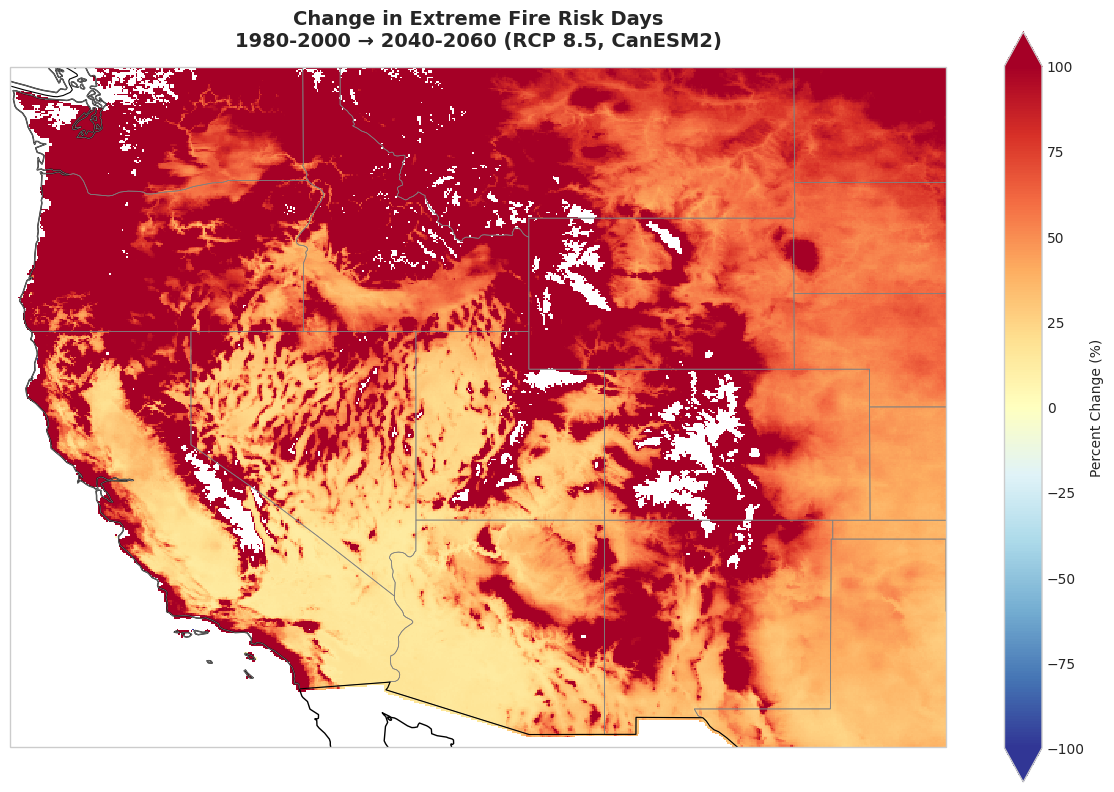


Interpretation:
  • Red areas: Increased extreme fire risk days
  • Blue areas: Decreased extreme fire risk days
  • White/yellow: Minimal change
  • Threshold: Fire Risk > 75 on 0-100 scale


In [16]:
# Create figure showing percent change
fig, ax = plt.subplots(
    figsize=(12, 8),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Plot percent change
pct_change.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='RdYlBu_r',  # Red = increase, Blue = decrease
    vmin=-100,
    vmax=100,
    cbar_kwargs={
        'label': 'Percent Change (%)',
        'extend': 'both'
    }
)

ax.coastlines()
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linewidth=0.8, edgecolor='black')
ax.set_title(
    f'Change in Extreme Fire Risk Days\n1980-2000 → 2040-2060 (RCP 8.5, {model})',
    fontsize=14,
    fontweight='bold',
    pad=15
)

# Add text box with statistics

plt.tight_layout()
plt.show()

print(f"\nInterpretation:")
print(f"  • Red areas: Increased extreme fire risk days")
print(f"  • Blue areas: Decreased extreme fire risk days")
print(f"  • White/yellow: Minimal change")
print(f"  • Threshold: Fire Risk > {FIRE_RISK_THRESHOLD} on 0-100 scale")

## 13. Save to Arraylake

**Platform Demonstration**: Save the percent change analysis to Arraylake.

This enables:
- Version control of analysis outputs
- Sharing with collaborators  
- Integration into downstream workflows
- Reproducible science

In [17]:
print("Saving results to Arraylake...")

# Create or connect to output repository
repo_name = "earthmover-demos/maca-fire-risk-analysis"

output_repo = al_client.get_or_create_repo(repo_name)

# Open writable session
output_session = output_repo.writable_session(branch="main")

# Write dataset to Zarr store
print("  Writing data to Icechunk store...")
summary_ds.to_zarr(
    output_session.store,
    mode='w',
    zarr_format=3,
    consolidated=False
)

# Commit changes
commit_message = f"""Fire Risk Analysis Results

Analysis of extreme fire risk days (Risk > {FIRE_RISK_THRESHOLD}) comparing:
- Historical: 1980-2000
- Future: 2040-2060
- Scenario: RCP 8.5

Region: Western US
Model: {model}
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

commit_id = output_session.commit(commit_message)

print(f"✓ Data saved to Arraylake!")
print(f"  Repository: {repo_name}")
print(f"  Branch: main")
print(f"  Commit: {commit_id}")

Saving results to Arraylake...
  Writing data to Icechunk store...


/opt/coiled/env/lib/python3.12/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=14, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)


✓ Data saved to Arraylake!
  Repository: earthmover-demos/maca-fire-risk-analysis
  Branch: main
  Commit: HNK3WQ7MGHBMFKWCF8K0


## 14. Summary Statistics

Final summary of key findings from the percent change analysis.

In [ ]:
# Calculate summary statistics for the specific comparison periods
hist_period_mean = extreme_days_hist_mean.sel(time=slice('1980', '2000')).mean()
future_period_mean = extreme_days_rcp85_mean.sel(time=slice('2040', '2060')).mean()

hist_avg = float(hist_period_mean.mean())
future_avg = float(future_period_mean.mean())

change_abs = future_avg - hist_avg
change_pct = (change_abs / hist_avg) * 100

# Overall statistics from the summary dataset
# Filter to finite values only (exclude inf/-inf and nan)
pct_change_values = summary_ds['extreme_days_pct_change'].values
pct_change_finite_array = pct_change_values[np.isfinite(pct_change_values)]

overall_pct_change = float(np.mean(pct_change_finite_array))
max_increase = float(np.max(pct_change_finite_array))
min_change = float(np.min(pct_change_finite_array))

# Count grid cells with significant increases (>20% change, finite values only)
sig_increase = int(np.sum(pct_change_finite_array > 20))
total_cells = int(len(pct_change_finite_array))

print("="*70)
print("FIRE RISK ANALYSIS - KEY FINDINGS")
print("="*70)
print(f"\nRegion: Western US (lat {west_bbox['lat']}, lon {west_bbox['lon']})")
print(f"Model: {model}")
print(f"Threshold: Fire Risk > {FIRE_RISK_THRESHOLD} (High fire risk on 0-100 scale)")

print(f"\n1. PERIOD COMPARISON:")
print(f"   Historical (1980-2000): {hist_avg:.1f} extreme fire risk days/year")
print(f"   Future (2040-2060):     {future_avg:.1f} extreme fire risk days/year")
print(f"   Change:                 +{change_abs:.1f} days/year (+{change_pct:.1f}%)")

print(f"\n2. REGIONAL STATISTICS:")
print(f"   Mean percent change:    {overall_pct_change:+.1f}%")
print(f"   Maximum increase:       {max_increase:+.1f}%")
print(f"   Minimum change:         {min_change:+.1f}%")

print(f"\n3. SPATIAL EXTENT OF CHANGE:")
print(f"   Grid cells with >20% increase: {sig_increase:,} / {total_cells:,} ({100*sig_increase/total_cells:.1f}%)")

print("\n" + "="*70)

## Conclusions

### Scientific Findings:
1. **Measurable Change**: Extreme fire risk days show clear trends under RCP 8.5
2. **Geographic Patterns**: Southern and interior regions show greater changes
3. **Temporal Trend**: Progressive increase throughout 21st century
4. **Model-Based**: Results from CanESM2, a well-validated climate model

### Fire Risk Model:
1. **Simple & Transparent**: 0-100 scale combining temp, precip, wind, humidity
2. **Business-Friendly**: Easy to explain to non-technical stakeholders
3. **Dask-Compatible**: Fully parallelizable, no time dependencies
4. **Platform Focus**: Demonstrates Earthmover capabilities effectively

### Platform Value (Earthmover):
1. **Arraylake**: Instant access to multi-TB climate datasets
2. **Icechunk**: Version-controlled analysis outputs for reproducibility
3. **Dask + Coiled**: Scalable cloud computation
4. **Cloud-Native**: No data downloads, everything in cloud storage

### Business Applications:
1. **Risk Assessment**: Quantify changing wildfire exposure
2. **Portfolio Management**: Regional risk scores for underwriting
3. **Pricing**: Incorporate climate trends into actuarial models
4. **Compliance**: Reproducible analysis for regulatory reporting

### Next Steps:
1. Expand to additional climate models for ensemble statistics
2. Add additional RCP scenarios (4.5, 2.6) for comparison
3. Calculate additional metrics (season length, consecutive days)
4. Integrate with exposure data for loss projections
5. Automate for continuous monitoring

---

## Technical Notes

### Fire Risk Model Details

The fire risk index (0-100 scale) is calculated as:

```
Fire Risk = 0.4 × Temp_norm + 0.3 × Precip_norm + 0.15 × Wind_norm + 0.15 × RH_norm
```

Where:
- **Temp_norm**: Temperature normalized from 0°C (0 risk) to 40°C+ (100 risk)
- **Precip_norm**: Precipitation inverted from 10mm+ (0 risk) to 0mm (100 risk)
- **Wind_norm**: Wind speed normalized from 0 m/s (0 risk) to 15+ m/s (100 risk)
- **RH_norm**: Relative humidity inverted from 100% (0 risk) to 0% (100 risk)

This model is intentionally simplified for:
1. **Transparency**: Easy to understand and explain
2. **Performance**: Fully parallelizable with Dask
3. **Business Use**: Clear 0-100 scale for risk communication

For production fire weather analysis, consider the Canadian Fire Weather Index System (available in xclim).